The goal of the Titanic competition is to predict who survived the disaster based on some information about the individual. The competition is described at https://www.kaggle.com/c/titanic/overview

Data Dictionary

Survival : 0 = No, 1 = Yes
Pclass : Ticket class,, 1st = Upper 2nd = Middle 3rd = Lower
sex: sex of the individual
Age: age in years
sibsp : The # of siblings / spouses aboard the Titanic Sibling = brother, sister, stepbrother, stepsister Spouse = husband, wife (mistresses and fiancés were ignored)
parch : The # of parents / children aboard the Titanic Parent = mother, father Child = daughter, son, stepdaughter, stepson Some children travelled only with a nanny, therefore parch=0 for them.
Ticket : Ticket number
Fare : Passenger fare
Cabin : Cabin number embarked
Port of Embarkation: C = Cherbourg, Q = Queenstown, S = Southampton

In [168]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter 
import scipy.stats as stats
import string

Loaded the train and test data into pandas data frame. Both the train and test data contain missing values. Train has is missing 177 age values, 687 cabin values and 2 embarked values. Test data is missing 86 age values, 1 fare value and 327 cabin values. The missing values will either need to be imputed (filled in based on training set data) or the rows will need to be removed. Used describe to look into the statistics of the numeric columns. No obvious outliers are observed in the data. 

In [169]:
target_column = ['Survived']
# load in the csv files
test = pd.read_csv('data_files/test.csv')
train = pd.read_csv('data_files/train.csv')
# determine the nans in each column
print('Missing values in train data')
print(train.isna().sum())
print('\nMissing values in test data')
print(test.isna().sum())
print('\nDescribe train data')
print(train.describe())
print('\nDescribe test data')
print(test.describe())

Missing values in train data
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Missing values in test data
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

Describe train data
       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.00

Created a function to check to see if any of the rows has invalid values (values that should not exist based on the data definition above). 

In [170]:
target_column = 'Survived'

# replace NaNs in the train and test dataframes with the missing value
#train.fillna(missing_value, inplace=True)
#test.fillna(missing_value, inplace=True)

check_values_dict = {'Survived':[0, 1], 
                     'Pclass':[1, 2, 3], 
                     'Sex':['male', 'female'],
                     'Embarked':['C', 'Q', 'S']}

def check_values(df, check_dict):
    return_dict = {}
    for (key, value) in check_dict.items():
        # check if the column exists in pandas
        if key in df.columns:
            # check column and see if there is any invalid values
            temp_bool_series = ~df.loc[~df[key].isnull(), key].isin(value)
            # if invalid values exist for the column. Store the row indices in dictionary
            if temp_bool_series.sum() > 0:
                return_dict[key] = temp_bool_series[temp_bool_series].index
        else:
            print('Column: ' + key + ' does not exist')
    return return_dict

def print_rows_with_invalid(df, invalid_dict):
    for (key, value) in invalid_dict.items():
        print(key + ' is invalid in the following rows')
        print(df.iloc[value])

print('Check if train has any invalid values')
print_rows_with_invalid(train, check_values(train, check_values_dict))
print('Check if test has any invalid values')
print_rows_with_invalid(test, check_values(test, check_values_dict))


Check if train has any invalid values
Check if test has any invalid values
Column: Survived does not exist


Feature conversion code

For most machine learning algorithms, all features must be represented as ints. First step is to convert sex into binary encoding.

In [171]:
def encode_sex(df):
    df['Sex'] = (df['Sex'].str.lower() == 'male').astype(int)
    return df

train = encode_sex(train)
test = encode_sex(test)

Last name may contain useful information because families may have been more likely to survive or perish together. Following function extracts the last name by assuming that the last name is to the left of the comma. The last name is coonverted to lower case to ensure that any capitalization is handled correctly. Additionally, the title was extracted because it may give a hint about age. First name was not extracted because it is unlikely to correlate with any person.

In [172]:
def parse_name(df):
    split_name_at_comma = df['Name'].str.split(',', n=1, expand=True)
    df['LastName'] = split_name_at_comma.get(0).str.lower()
    split_name_at_period = split_name_at_comma.get(1).str.split('.', n=1, expand=True)
    df['Title'] = split_name_at_period.get(0).str.lower()
    df.drop('Name', axis=1, inplace=True)
    return df

# extract last name
train = parse_name(train)
#print(train.head())
test = parse_name(test)
#print(test.head())

Ticket column contains letters and numbers. This column will be broken up into before and after the space. For the text porition of the ticket number, the string is converted to lower case and the punctuation is stripped from the string. 

In [173]:
# create dictionary of punctuation to remove
punctuation_table = str.maketrans(dict.fromkeys(string.punctuation))

def parse_ticket(df, punctuation_table):
    # split ticket at the first space
    split_ticket_at_space = df['Ticket'].str.split(' ', n=1, expand=True)
    # convert to lower case and remove the punctuation
    temp = split_ticket_at_space.get(0).str.lower().str.translate(punctuation_table)
    df['TicketHeader'] = temp[~temp.str.isnumeric()]
    df['TicketNumber'] = temp[temp.str.isnumeric()]
    df.loc[~temp.str.isnumeric(), 'TicketNumber'] = split_ticket_at_space.get(1)
    df['TicketNumber'] = df['TicketNumber'].astype('int64')
    return df

def parse_ticket_regexp(df):
    # Extract letters from the ticket, combine into one string and convert to lower case
    df['TicketLetters'] = df['Ticket'].str.findall(r'[A-Za-z]+').str.join('').str.lower()
    # Extract numbers from the ticket, combine to one string, replace empty strings with NaNs and convert to numeric
    df['TicketNumbers'] = pd.to_numeric(df['Ticket'].str.findall(r'[0-9]+').str.join('').replace('', np.nan))
    df.drop('Ticket', axis=1, inplace=True)
    return df
    

#print(parse_ticket(train, punctuation_table).dtypes)
#print(parse_ticket(train, punctuation_table).head())
#print(parse_ticket_regexp(train).head())

train = parse_ticket_regexp(train)
test = parse_ticket_regexp(test)

Filling in NaNs

The columns age, cabin, embarked and fare have NaN values. Exploratory data anlysis is performed to see the correlation between parameters with goal of using a different parameter to guess what the missing value should be.

Train has is missing 177 age values, 687 cabin values and 2 embarked values. Test data is missing 86 age values, 1 fare value and 327 cabin values.

Fare and Pclass should be correlated. Higher fare with better class (lower number). Histogram was created to look for the correlation. Pclass = 1 has higher ticket price than Pclass = 2 and 3. The fare is non gaussin for the different Pclasses

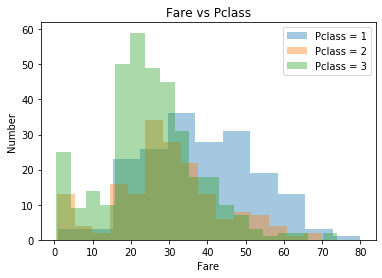

In [174]:
df = train[train['Pclass'] == 1]
sns.distplot(df['Age'].dropna(),  kde=False, label='Pclass = 1')
df = train[train['Pclass'] == 2]
sns.distplot(df['Age'].dropna(),  kde=False, label='Pclass = 2')
df = train[train['Pclass'] == 3]
sns.distplot(df['Age'].dropna(),  kde=False, label='Pclass = 3')
plt.legend()
plt.title('Fare vs Pclass')
plt.xlabel('Fare')
plt.ylabel('Number')
plt.show()

In [175]:
print(test[test['Fare'].isnull()])

     PassengerId  Pclass  Sex   Age  SibSp  Parch  Fare Cabin Embarked  \
152         1044       3    1  60.5      0      0   NaN   NaN        S   

    LastName Title TicketLetters  TicketNumbers  
152   storey    mr                         3701  


In [176]:
correlation_matrix_male_survived = pd.crosstab(train['Survived'], train['Sex'], rownames=['Survived'], colnames=['Sex'])
print(correlation_matrix_male_survived)
print(train.groupby('Sex')['Survived'].agg(np.mean))
#Male is a good feature

Sex         0    1
Survived          
0          81  468
1         233  109
Sex
0    0.742038
1    0.188908
Name: Survived, dtype: float64


In [177]:
correlation_matrix_pclass_survived = pd.crosstab(train['Survived'], train['Pclass'], rownames=['Survived'], colnames=['Pclass'])
print(correlation_matrix_pclass_survived)
print(train.groupby('Pclass')['Survived'].agg(np.mean))
#Pclass is a good feature

Pclass      1   2    3
Survived              
0          80  97  372
1         136  87  119
Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64


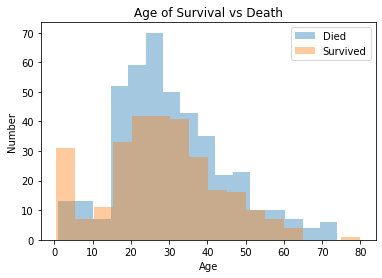

In [178]:
#age_bins = list(range(0,100,10))
df = train[train['Survived'] == 0]
sns.distplot(df['Age'].dropna(),  kde=False, label='Died')
df = train[train['Survived'] == 1]
sns.distplot(df['Age'].dropna(),  kde=False, label='Survived')
plt.legend()
plt.title('Age of Survival vs Death')
plt.xlabel('Age')
plt.ylabel('Number')
plt.show()

In [179]:
# look into age affects survival
train['AgeDecade'] = (train['Age'] / 10).apply(np.floor)
trained_grouped_by_age_decade = train.groupby('AgeDecade')
print(trained_grouped_by_age_decade['Survived'].agg(np.mean))
print(trained_grouped_by_age_decade['Survived'].count())

AgeDecade
0.0    0.612903
1.0    0.401961
2.0    0.350000
3.0    0.437126
4.0    0.382022
5.0    0.416667
6.0    0.315789
7.0    0.000000
8.0    1.000000
Name: Survived, dtype: float64
AgeDecade
0.0     62
1.0    102
2.0    220
3.0    167
4.0     89
5.0     48
6.0     19
7.0      6
8.0      1
Name: Survived, dtype: int64


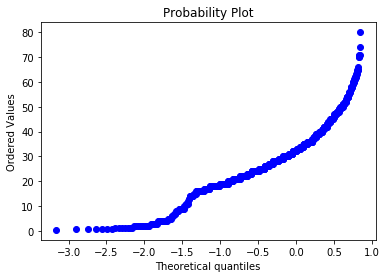

In [180]:
stats.probplot(train["Age"], dist="norm", plot=plt)
plt.show()
# data does not have normal distribution because not on 45 degree line

In [181]:
print(train.groupby('SibSp')['Survived'].agg(np.mean))
print(train.groupby('SibSp')['Survived'].count())

SibSp
0    0.345395
1    0.535885
2    0.464286
3    0.250000
4    0.166667
5    0.000000
8    0.000000
Name: Survived, dtype: float64
SibSp
0    608
1    209
2     28
3     16
4     18
5      5
8      7
Name: Survived, dtype: int64


In [182]:
print(train.groupby('Parch')['Survived'].agg(np.mean))
print(train.groupby('Parch')['Survived'].count())

Parch
0    0.343658
1    0.550847
2    0.500000
3    0.600000
4    0.000000
5    0.200000
6    0.000000
Name: Survived, dtype: float64
Parch
0    678
1    118
2     80
3      5
4      4
5      5
6      1
Name: Survived, dtype: int64


In [183]:
print(train.groupby('Embarked')['Survived'].agg(np.mean))
print(train.groupby('Embarked')['Survived'].count())
# suprisingly this looks like a good feature

Embarked
C    0.553571
Q    0.389610
S    0.336957
Name: Survived, dtype: float64
Embarked
C    168
Q     77
S    644
Name: Survived, dtype: int64


Cabin
A10    0.0
A14    0.0
A16    1.0
A19    0.0
A20    1.0
      ... 
F33    1.0
F38    0.0
F4     1.0
G6     0.5
T      0.0
Name: Survived, Length: 147, dtype: float64
Cabin
A10    1
A14    1
A16    1
A19    1
A20    1
      ..
F33    3
F38    1
F4     2
G6     4
T      1
Name: Survived, Length: 147, dtype: int64


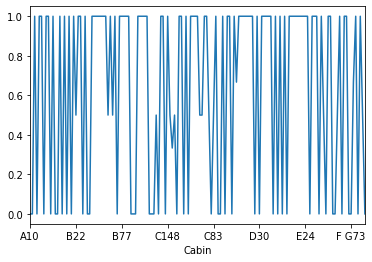

In [184]:
survival_by_cabin = train.groupby('Cabin')['Survived']
print(survival_by_cabin.agg(np.mean))
print(survival_by_cabin.count())
#print(survival_by_cabin.loc[survival_by_cabin.count() > 1])
survival_by_cabin.agg(np.mean).plot()
plt.show()


In [185]:
def most_frequent(input_list):
    if not input_list:
        return ''
    else:
        occurence_count = Counter(input_list)
        return occurence_count.most_common(1)[0][0] 

In [186]:
print(most_frequent(['A', 'B', 'A']))
print(most_frequent(['']))

A



    PassengerId  Survived  Pclass  Sex   Age  SibSp  Parch      Fare  \
3             4         1       1    0  35.0      1      0   53.1000   
10           11         1       3    0   4.0      1      1   16.7000   
27           28         0       1    1  19.0      3      2  263.0000   
52           53         1       1    0  49.0      1      0   76.7292   
62           63         0       1    1  45.0      1      0   83.4750   

          Cabin Embarked   LastName  Title TicketLetters  TicketNumbers  \
3          C123        S   futrelle    mrs                     113803.0   
10           G6        S  sandstrom   miss            pp         9549.0   
27  C23 C25 C27        S    fortune     mr                      19950.0   
52          D33        C     harper    mrs            pc        17572.0   
62          C83        S     harris     mr                      36973.0   

    AgeDecade  
3         3.0  
10        0.0  
27        1.0  
52        4.0  
62        4.0  


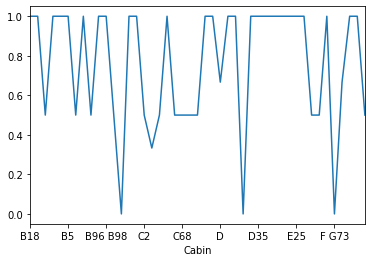

In [187]:
# Cabin, Embarked, and age have missing values
# find cabins with more than one person
cabin_more_than_one_person = train[train['Cabin'].duplicated(keep=False)].dropna()
print(cabin_more_than_one_person.head())
cabin_more_than_one_person.groupby('Cabin')['Survived'].agg(np.mean).plot()
plt.show()

In [188]:
# break up the cabin column into level and number. Need to check for correlation between different features. Ex.
# pclass and cabin letter are likely correlated
#train['CabinLetter'] = train['Cabin'].str.extract(r"^[a-zA-Z]+").lower()
#s = pd.Series(['C1', 'A1 A2 A3', 'D3'])
#s.str.findall(r'[A-Za-z]', flags=re.IGNORECASE)
train['Cabin'] = train['Cabin'].replace(np.nan, '', regex=True).str.lower()
train['CabinLetter'] = train['Cabin'].str.findall(r'[A-Za-z]', flags=re.IGNORECASE).apply(lambda x: most_frequent(x))
print(train['CabinLetter'].value_counts())

     687
c     59
b     47
d     33
e     32
a     15
f     13
g      4
t      1
Name: CabinLetter, dtype: int64


CabinLetter
     0.299854
a    0.466667
b    0.744681
c    0.593220
d    0.757576
e    0.750000
f    0.615385
g    0.500000
t    0.000000
Name: Survived, dtype: float64
CabinLetter
     687
a     15
b     47
c     59
d     33
e     32
f     13
g      4
t      1
Name: Survived, dtype: int64


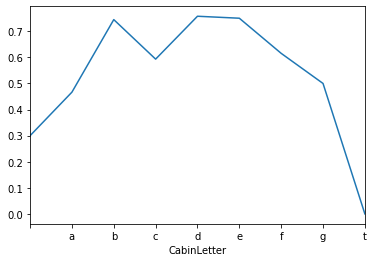

In [189]:
survival_by_cabin_letter = train.groupby('CabinLetter')['Survived']
print(survival_by_cabin_letter.agg(np.mean))
print(survival_by_cabin_letter.count())
#print(survival_by_cabin.loc[survival_by_cabin.count() > 1])
survival_by_cabin_letter.agg(np.mean).plot()
plt.show()

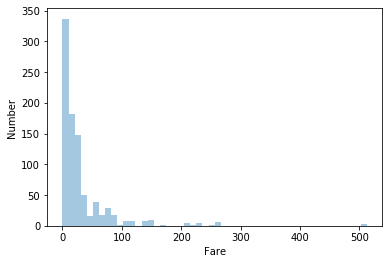

In [190]:
#age_bins = list(range(0,100,10))
sns.distplot(train['Fare'].dropna(),  kde=False, label='Died')
plt.xlabel('Fare')
plt.ylabel('Number')
plt.show()

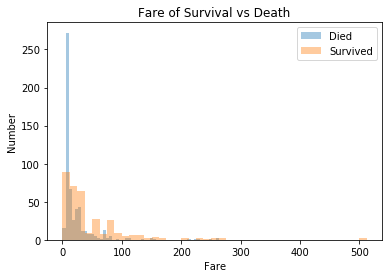

In [191]:
#age_bins = list(range(0,100,10))
df = train[train['Survived'] == 0]
sns.distplot(df['Fare'].dropna(),  kde=False, label='Died')
df = train[train['Survived'] == 1]
sns.distplot(df['Fare'].dropna(),  kde=False, label='Survived')
plt.legend()
plt.title('Fare of Survival vs Death')
plt.xlabel('Fare')
plt.ylabel('Number')
plt.show()

[]

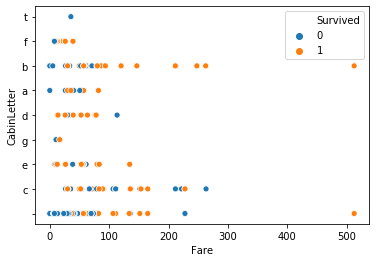

In [192]:
sns.scatterplot(x=train['Fare'], y=train['CabinLetter'], hue=train['Survived'])
plt.plot()

In [193]:
print(train.head(20))

    PassengerId  Survived  Pclass  Sex   Age  SibSp  Parch     Fare Cabin  \
0             1         0       3    1  22.0      1      0   7.2500         
1             2         1       1    0  38.0      1      0  71.2833   c85   
2             3         1       3    0  26.0      0      0   7.9250         
3             4         1       1    0  35.0      1      0  53.1000  c123   
4             5         0       3    1  35.0      0      0   8.0500         
5             6         0       3    1   NaN      0      0   8.4583         
6             7         0       1    1  54.0      0      0  51.8625   e46   
7             8         0       3    1   2.0      3      1  21.0750         
8             9         1       3    0  27.0      0      2  11.1333         
9            10         1       2    0  14.0      1      0  30.0708         
10           11         1       3    0   4.0      1      1  16.7000    g6   
11           12         1       1    0  58.0      0      0  26.5500  c103   